# Lesson 3: A full-fledged application to physics

In this chapter, we employ a neural network to extract the underlying parameters of a physical system. The physical system is a nonlinear (Duffing) oscillator, and we simulate its response curve under driving.

The response curve will be fed into the network, and it has to come up with the values of resonance frequency, nonlinearity, and damping. These values have been changed randomly during training.

(C) 2024 Florian Marquardt, Max Planck Institute for the Science of Light (MIT License)

## Imports and little helper routines

In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random

import optax

from functools import partial

import tqdm

### Little helper routine for initializing neural network

As before, in the previous chapter.

In [2]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

### Runge Kutta solver (using jax, so it can easily be parallelized, run on GPU, etc)

A parallelizable Runge Kutta solver (hidden, since it is not the main topic here).

In [3]:
def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

# we need this partial statement to tell jax
# that the 'rhs' argument is not an array but something
# else!
@partial(jax.jit,static_argnames=['rhs'])
def runge_kutta_solve(X0,rhs,ts,params):
    """
    Solve the differential equation dX/dt=rhs(X,params,t), for all (equally spaced) times in ts,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,params,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020, 2024)
    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        x+=runge_kutta_step_with_params(x,params,t,rhs,dt)
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,xs=ts)
    return Xs,ts

# batched parameters:
parallel_param_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[None,None,None,0],
                                                   out_axes=0)

# batched initial conditions:
parallel_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[0,None,None,None],
                                                   out_axes=0)

## Apply neural networks to predict the physical parameters from response curves in the Duffing model of a nonlinear driven oscillator

### Duffing equation and the Duffing model solver

The equation of motion of a driven nonlinear (Duffing) oscillator can be written like this, with some simplifications:

$$
{\dot z} = -i (\omega_0 - \omega) z - {\gamma \over 2} z - i  {\varepsilon} |z|^2 z + i f
$$

Here $\omega_0$ is the resonance frequency (counted from some offset that itself is already much larger than the damping rate and everything else), $\omega$ is the driving frequency, $\gamma$ the damping rate, and $\varepsilon$ the strength of the nonlinearity, while $f$ is the strength of the external oscillating force. The response curves display the famous "shark fin" shape once the driving or the nonlinearity get stronger. For the experts: we have been using the so-called "rotating-wave approximation" in writing down the above equation. 

Now let us define the right hand side of the differential equation as a python function, ```duffing_rhs```. In addition, we set up a function ```solve_duffing``` that will solve this equation of motion of the Duffing oscillator. It assumes that we sweep the frequency with time, as one would do in a real response experiment. This function will later be used to generate the training samples.

In [4]:
def duffing_rhs(z,rhs_params,t):
    # params = [omega_start, domega_dt , gamma, epsilon, force, omega0]
    return ( (-1j*(rhs_params[5]-(rhs_params[0]+rhs_params[1]*t)) - 0.5*rhs_params[2])*z 
            -1j*rhs_params[3]*jnp.abs(z)**2 * z + 1j*rhs_params[4] )

def solve_duffing(z0, omega0, gamma, epsilon, force, omega_start, omega_stop, t_end, nsteps):
    ts=jnp.linspace(0.,t_end, nsteps)
    domega_dt = (omega_stop - omega_start)/t_end 
    rhs_params=jnp.array([omega_start, domega_dt , gamma, epsilon, force, omega0])
    omegas=omega_start + domega_dt * ts
    return *runge_kutta_solve(z0, duffing_rhs, ts, rhs_params),omegas

# batch-processing version, where omega0,gamma,epsilon can vary across
# the samples of the batch:
solve_duffing_parameter_batch = vmap(solve_duffing,
                                    in_axes=[None,0,0,0,None,None,None,None,None])

# batch-processing version, which can be used to compute a force sweep:
solve_duffing_force_batch = vmap(solve_duffing,
                                 in_axes=[None,None,None,None,0,None,None,None,None],
                                out_axes=0)


As you can see, we have again used ```vmap``` to produce two batched versions that are able to run the Duffing simulator for a batch of parameters (omega0, gamma, epsilon) or a batch of different force values.

Now let us run a first test of our Duffing solver, for one set of parameters, and plot the resulting response curve.

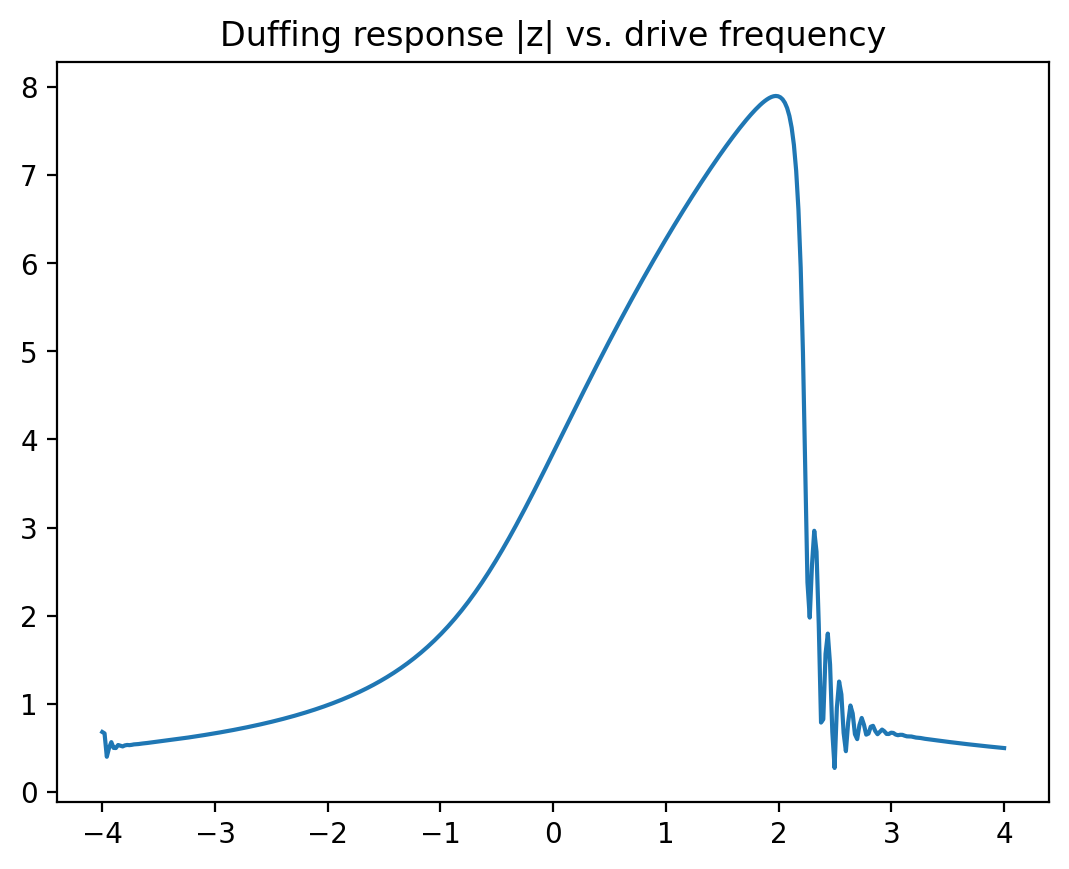

In [5]:
zs,ts,omegas = solve_duffing( 0.0+0.01j, omega0=0.0, omega_start=-4.0, 
                    omega_stop=+4.0, gamma=.5, 
                      epsilon=0.03, force=2.0, 
                      t_end=200.0, nsteps=400 )

plt.plot(omegas,jnp.abs(zs))
plt.title("Duffing response |z| vs. drive frequency")
plt.show()

Next, we would like to do the same, but for a variety of different force strengths. We use the ```solve_duffing_force_batch``` that was defined above, to do this without a for loop. Note that to use this batched function properly, we cannot name the arguments any more (unlike above):

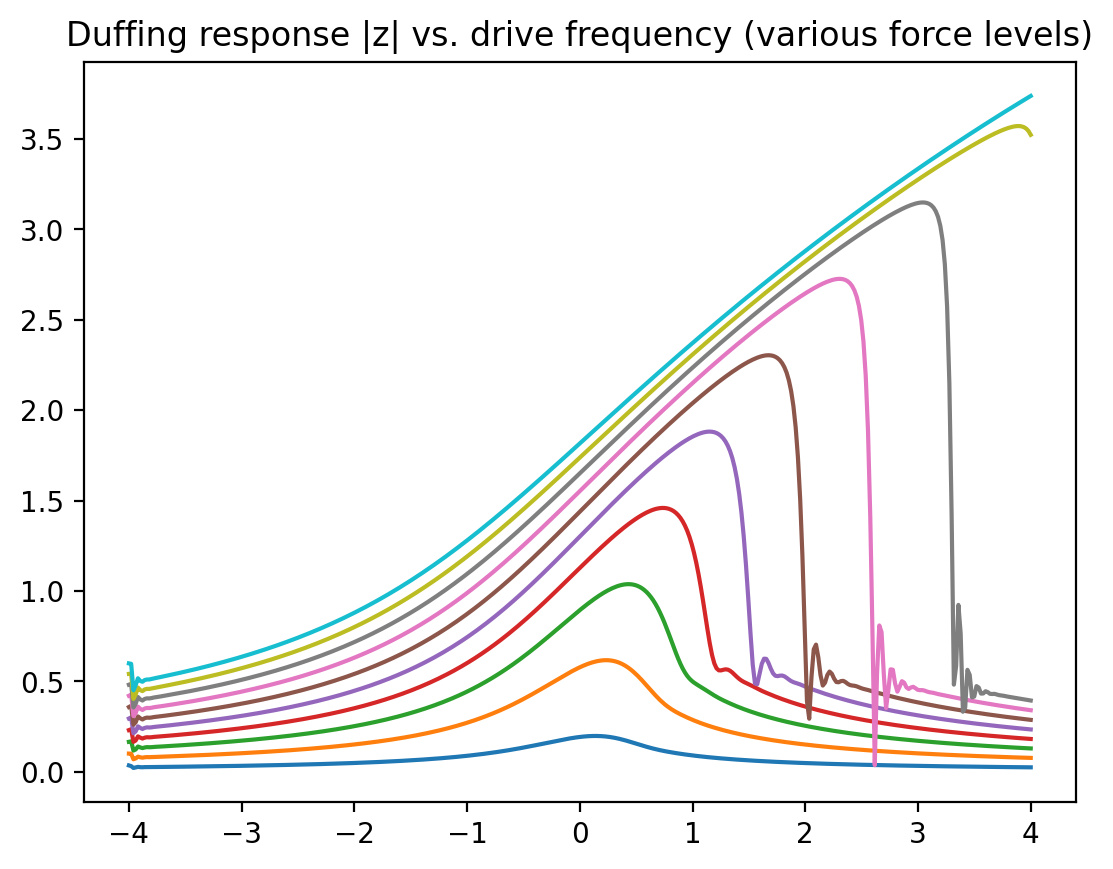

In [6]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0,
                                     1.0, 
                      0.3, jnp.linspace(0.1,2.0,10), 
                     -4.0, +4.0,
                      200.0, 400 )

for j in range(10):
    plt.plot(omegas[j],jnp.abs(zs[j]))
plt.title("Duffing response |z| vs. drive frequency (various force levels)")
plt.show()

### Train a neural network to predict the parameters by looking at one response curve

#### Producing the training samples

In all slightly more advanced machine learning applications, some of the main effort goes into producing the training samples. Sometimes they are obtained from experiments, sometimes collected from the internet. In our case, we produce them via simulations, using the solver we built above. We thus have to set up a function that will produce a batch of response curves for a set of randomly chosen parameter values.

We now define a little helper routine that produces a training batch of response curves for randomly chosen resonance frequency (omega0), nonlinearity (epsilon), and damping (gamma).

In [7]:
def random_parameter_vectors( key, batchsize , ranges ):
    """
    Produce several vectors of length batchsize, with values randomly
    uniformly distributed within the respective values range [min_val,max_val].
    ranges is a list of such value ranges.
    
    Returns: list of random vectors.
    """
    subkeys = jax.random.split( key, len(ranges) )
    return [ jax.random.uniform( subkey, [ batchsize ], 
                                      minval = value_range[0], maxval = value_range[1] )
            for subkey, value_range in zip(subkeys, ranges) ]

def duffing_produce_training_batch( key, batchsize, ranges , num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400):
    """
    Produce a Duffing model training batch.
    Random values for omega0, gamma, and epsilon are generated uniformly
    in the ranges given in the list 'ranges' (a list of [min_val,max_val] entries).
    
    Returns:
    x, y_target
    
    where
    
    x is of shape [batchsize, num_frequency_bins] and represents the response curves
    y_target is of shape [batchsize, 3] and gives (omega0,gamma,epsilon) for each sample
    """
    omega0s, gammas, epsilons = random_parameter_vectors( key, batchsize, ranges )
    zs,_,_ = solve_duffing_parameter_batch( 0.0+0.0j, omega0s, gammas, epsilons, 
                                 force, omega_start, omega_end, t_end, n_steps )
    x = jax.image.resize( jnp.abs(zs), [ batchsize, num_frequency_bins ] , "linear")
    return x, jnp.stack([omega0s,gammas,epsilons],1)
     
    

Let us illustrate the variety of response curves one gets in a batch:

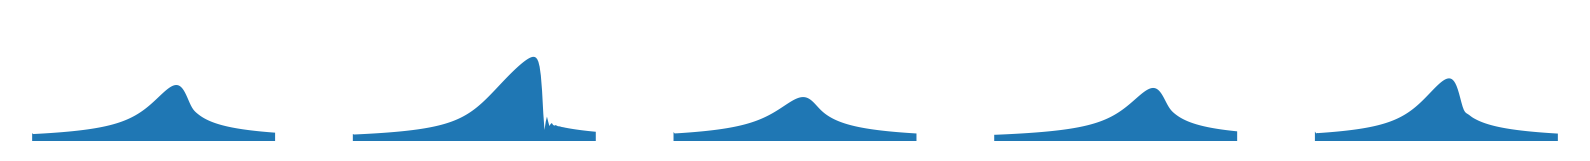

In [8]:
key = jax.random.key( 44 )
num_panels = 5
npixels = 200

x, y_target = duffing_produce_training_batch( key, num_panels, 
                                             [[-1.,1.],[0.5,1.5],[0.0,0.15]], npixels)

omegas = jnp.linspace(-4.,4.,npixels)
fig,ax=plt.subplots(ncols = num_panels, sharey = True, figsize=(10,2))
for idx in range(num_panels):
    ax[idx].fill_between(omegas,0*omegas,x[idx,:])
    ax[idx].set_ylim(0.,4.)
    ax[idx].set_aspect(1.0)
    ax[idx].axis('off')
    omega0,gamma,epsilon=y_target[idx,:]
plt.show()

#### Defining the neural network

We define the same  standard multilayer perceptron (fully connected network) that we used in the previous chapter.

In [9]:
def NN(x, params):
    """
    Standard MLP with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.
    """
    num_layers=len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'],params['biases'])):
        x = jnp.matmul(w,x) + b
        if layer_idx < num_layers-1:
            x = jnp.tanh( x )
    return x

# produce a batched version (where x has a batch dimension 0)
NN_batch = vmap(NN, in_axes=[0,None], out_axes=0)

# batch-averaged mean-square-error deviation between network output and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss. Apply jit to compile it:
mse_loss_batch_val_grad = jax.jit( value_and_grad(mse_loss_batch, argnums=2) )

#### Initializing parameters

Let us initialize the neural network parameters and prepare the optax optimizer.

In [10]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

We also prepare some parameters for the training loop.

In [11]:
# training parameters
num_training_batches = 100
batchsize = 32
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]


#### Training

Now we can run the training loop! As usual, in each iteration we produce a training batch, evaluate the network on this batch, get the gradients of the loss function with respect to the neural network parameters, and finally update the parameters

Note: If you want a nice progress bar during training, insert ```from tqdm import tqdm``` at the top of the cell and then use ```tqdm(range(...))``` instead of ```range```.

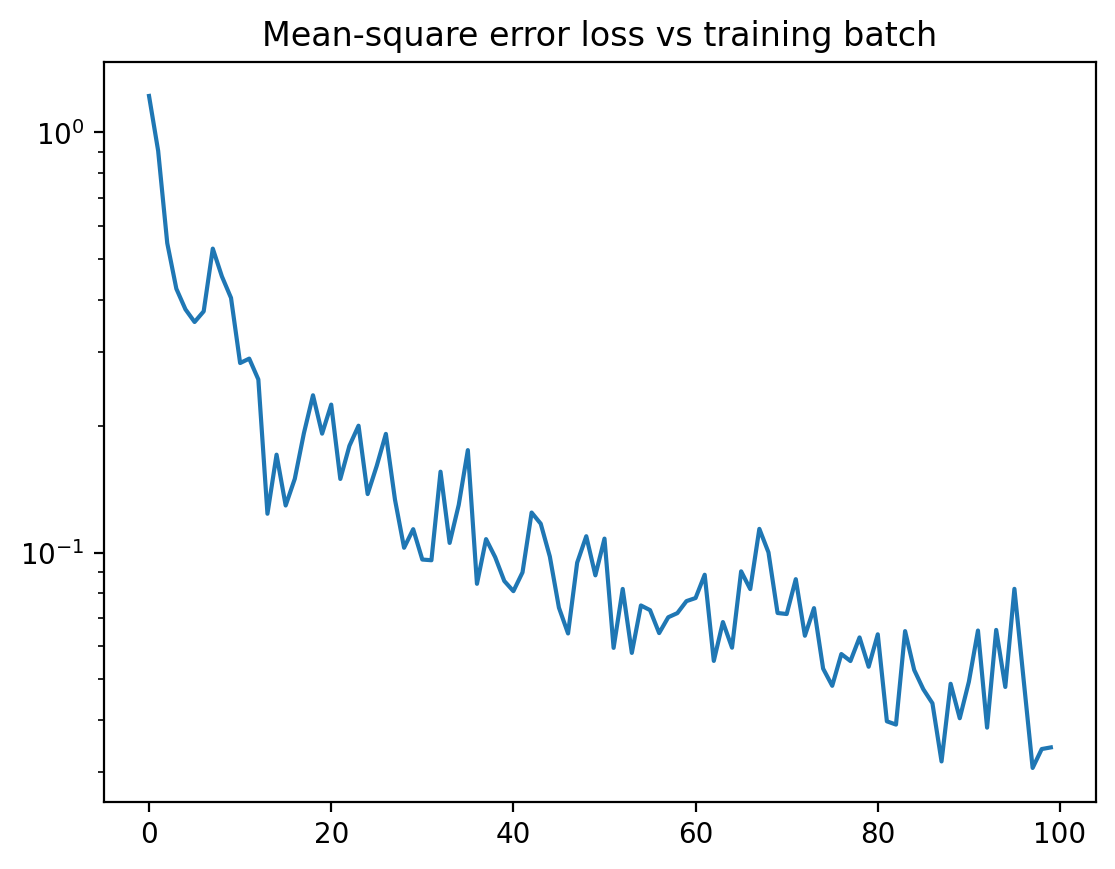

In [12]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = duffing_produce_training_batch( subkey, batchsize, 
                                                 value_ranges, num_frequency_bins)
        
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

Now let us test how well the neural network actually performs. Run it on a random training batch (now of larger batchsize). Then plot the network's predictions for the parameters vs the true parameter values, which are known in the training batch.

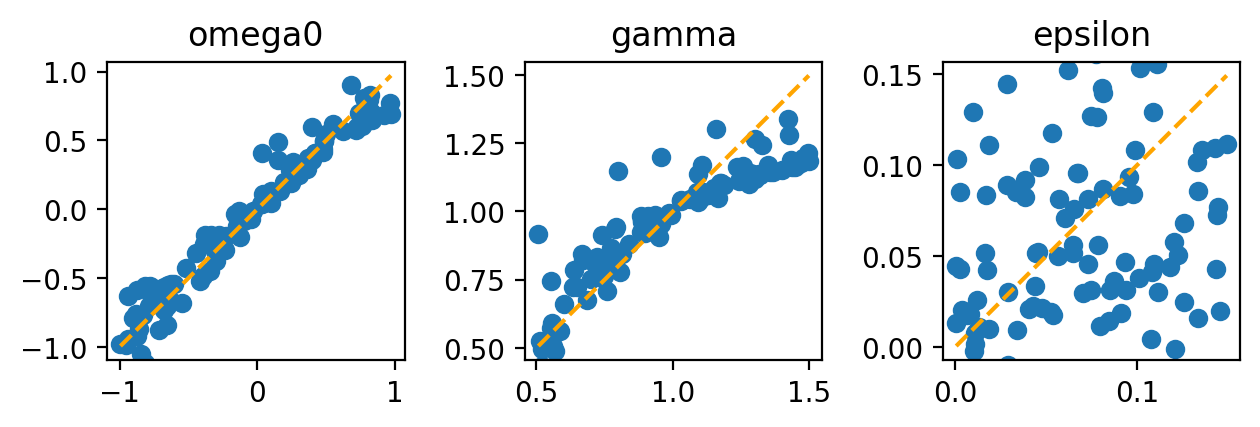

In [13]:
subkey,key = jax.random.split( key )
x, y_target = duffing_produce_training_batch( subkey, 100, 
                                             value_ranges, num_frequency_bins)
y = NN_batch(x,params)

fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

Ideally, all the dots should lie on the orange line, indicating that the network prediction (vertical) is identical to the true value (horizontal). Apparently, it is most difficult for the network to make good predictions for the nonlinearity strength ```epsilon```.

```{admonition} Exercise
Run the training loop above several times (or set the num_training_batches to a higher value and then run it). After each run, observe that the network performs better!
```

```{admonition} Exercise
Add noise to the training samples, by writing a new training_batch function that calls the old one and adds noise. Use jax.random.normal. Make sure not to forget to split the random key, as shown already in the training loop! Observe how the network can learn in spite of the noise. Also, plot a few of the noisy response curves.
```

### The danger of overfitting: Training on only a few samples

So far, we have had abundant training data: Each sample was freshly simulated, with new randomly chosen parameters. However, if data come from experiments instead of simulations, one often only has a limited amount of training samples. Then, a new and dangerous phenomenon can occur.

Let us mimick the experimental situation by producing a fixed number of samples from our simulation:

In [14]:
num_training_samples = 64
train_x, train_y_target = duffing_produce_training_batch( subkey, num_training_samples, 
                                             value_ranges, num_frequency_bins)


This is now all the data we have to work with. In order to deal with that situation in training, one proceeds in the following standard fashion. In each "epoch" of training, one goes through all the samples in the training data set, in a random order. This can be achieved by setting up a random permutation of all indices of the training samples:

```python
epoch_indices = jax.random.choice(subkey,jnp.arange(num_training_samples), 
    (num_training_samples,), replace=False)
```

We then subdivide this into batches and perform one training step on each batch, like before. As soon as all the training data has been seen once by the neural network in this fashion, one starts the next epoch.

Set up the usual initialization, like before...

In [15]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

# training parameters
num_training_epochs = 1000
batchsize = 16
num_batches_per_epoch = num_training_samples//batchsize

value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]


Now run the training loop, with this subdivision into epochs, each of which runs through all the batches of the fixed training data set:

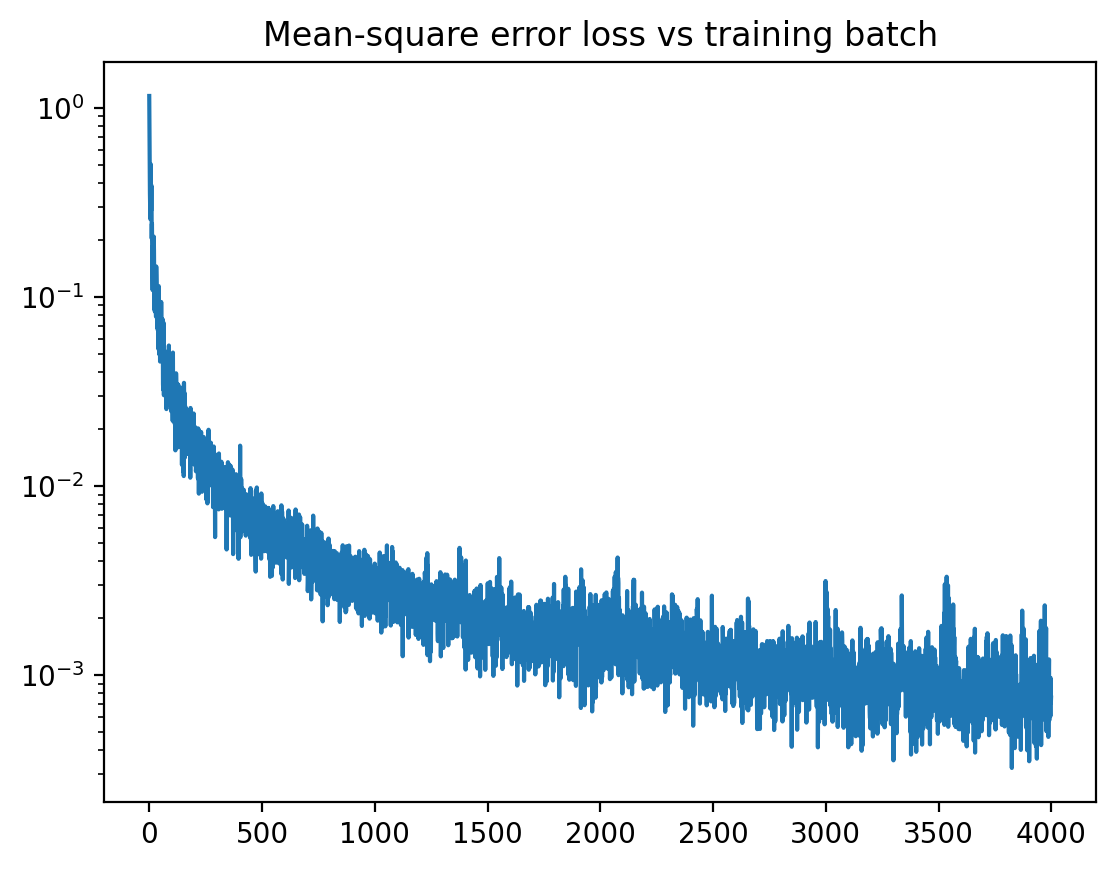

In [16]:
# run this cell multiple times to continue training!

for idx_epoch in range(num_training_epochs):
    # get a random permutation of sample indices:
    subkey,key = jax.random.split( key )
    epoch_indices = jax.random.choice(subkey, 
                        jnp.arange(num_training_samples), 
                        (num_training_samples,), replace=False)

    for idx_batch in range(num_batches_per_epoch):
        # get training batch:
        indices_batch = epoch_indices[idx_batch*batchsize:(idx_batch+1)*batchsize]
        x, y_target = train_x[indices_batch], train_y_target[indices_batch]

        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad( x, y_target, params )

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state)
        params = optax.apply_updates( params, updates )

        # add the loss to the list:
        losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()



Let us now check how well the network performs. We will now actually test the performance twice: once on the existing training data set, and once on an independent, freshly drawn set of samples. Let us see what happens!

Evaluation on training data set


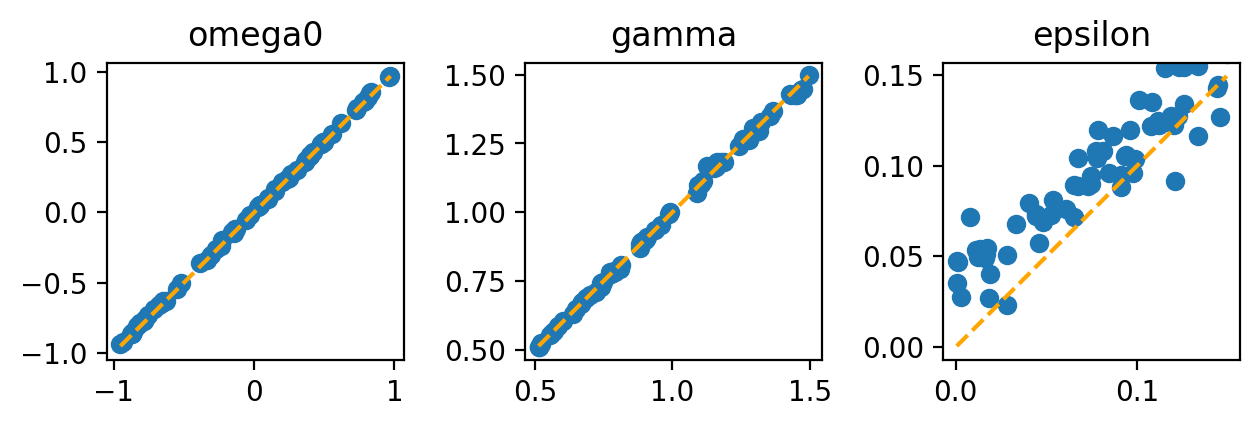

Evaluation on fresh data set


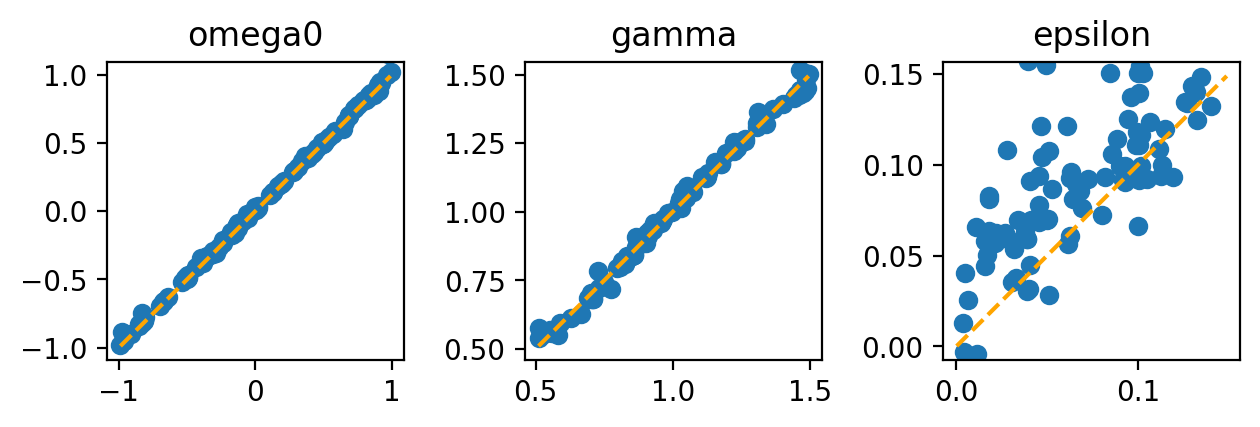

In [17]:
for idx_figure in range(2):
    if idx_figure==0:
        x, y_target = train_x, train_y_target
        print("Evaluation on training data set")
    else:
        subkey,key = jax.random.split( key )
        x, y_target = duffing_produce_training_batch( subkey, 100, 
                                                 value_ranges, num_frequency_bins)
        print("Evaluation on fresh data set")

    y = NN_batch(x,params)
        
    fig,ax = plt.subplots(ncols=3)
    for idx, label in enumerate(["omega0","gamma","epsilon"]):
        ax[idx].scatter(y_target[:,idx],y[:,idx])
        min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
        ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
        ax[idx].set_ylim(ax[idx].get_xlim())
        ax[idx].set_title(label)
        ax[idx].set_aspect(1.0)
    fig.tight_layout()
    plt.show()


If you look closely, you can already begin to see that the performance on the existing training set is getting a bit better than on the freshly drawn set. This effect increases with increasing training time (try it by continuing to train!). 

That observation is actually bad news! It means that the network does not generalize its performance well. In fact, it has started to "overfit" (or memorize) the samples of the training set, instead of understanding the general structure of the problem. This problem of "overfitting" can be severe. The solution is to always to keep a small piece of the existing data separate from the training data, as a so-called "validation" data set, and to check the network's performance there. This is the performance that counts, since it will not be affected by overfitting. Of course, overfitting only exists as a problem in situations where we train repeatedly on the same data (because data is scarce), instead of producing fresh data for every batch.

Training should be stopped when the performance on the validation data set does not improve anymore (it will actually decrease again when the network starts to overfit). This is called "early stopping". Another technique to avoid overfitting is to inject noise into the network activations during training, which prevents the network from adjusting too much to the details of the training data set. This is called "dropout" (because in some versions, one simply randomly drops some activations, setting them to zero).

Experts go even one step further, holding out some test data that is never looked at during training (not even for evaluating the performance, i.e. not even in the way the validation set is used). It can finally be used to assess the network performance independently. Sometimes the test data is of course not even yet known during training time.

## Train a neural network to predict the parameters by looking at a 2D image

Let us produce a frequency / force sweep to generate a 2D image of the type that could come from an experiment:

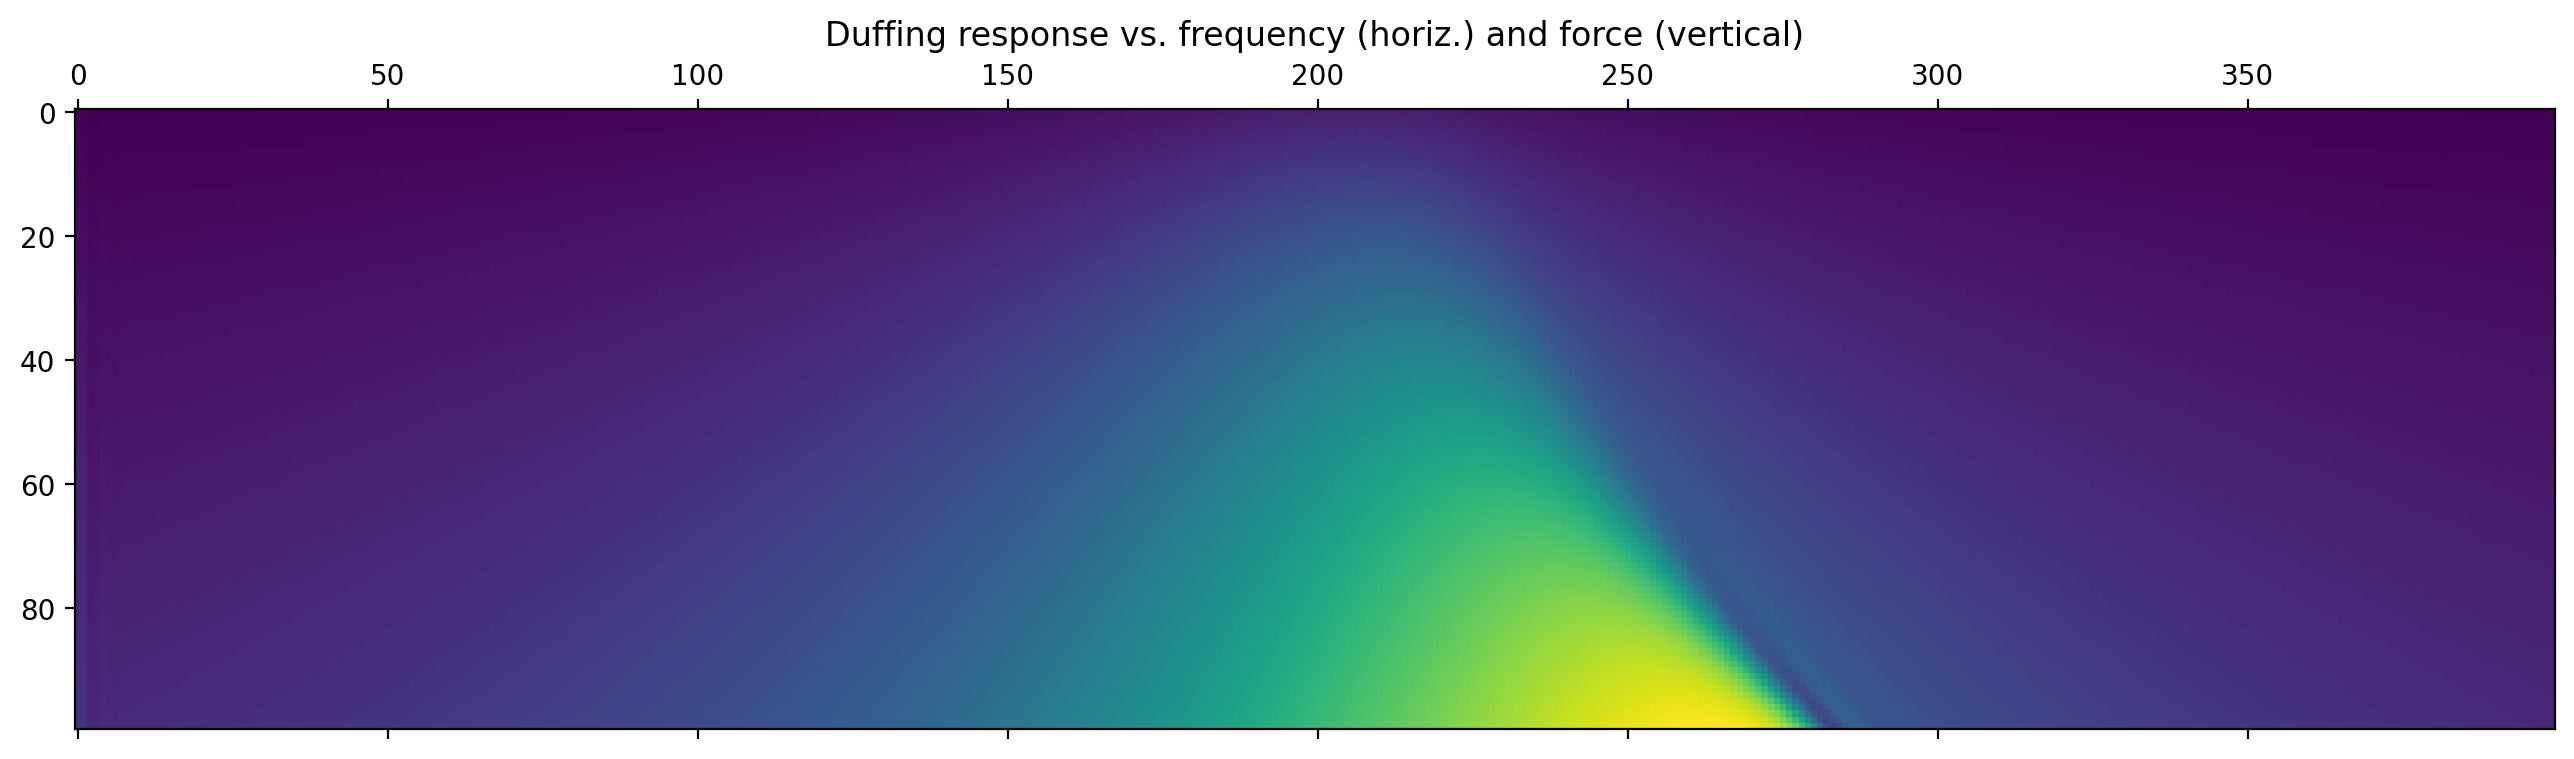

In [18]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0, 1.0, 
                      0.3, jnp.linspace(0.1,1.0,100), -4.0, 
                    +4.0,
                      200.0, 400 )

plt.matshow( jnp.abs(zs) )
plt.title("Duffing response vs. frequency (horiz.) and force (vertical)")
plt.show()

Now we turn this into a function that produces one image, then use ```vmap``` to make it batched, and use that to define ```get_duffing_image_batch``` which will produce a batch of images with randomly chosen ```omega0```, ```gamma```, ```epsilon```. This works in analogy to what we had before in the case of response curves, only now with images instead of curves. For good measure, we also add noise, since real experiments have noise!

There is one additional trick we introduce: It helps the neural network to know, for each location inside the image, what is the associated frequency and force value. We therefore add two extra channels to the response image which indicate the frequency and the force value.

In [19]:
def produce_force_sweep_image(key, omega0,epsilon,gamma, npixels, 
                              omega_range, low_force, high_force, 
                              t_end, nsteps, noise_strength):
    zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, omega0, gamma, 
                      epsilon, jnp.linspace(low_force,high_force,npixels), -omega_range, +omega_range,
                      t_end, nsteps )
    # downscale image (less data for the network to process):
    resized_img = jax.image.resize(jnp.abs(zs), (npixels,npixels), "cubic")
    # add noise:
    resized_img+= noise_strength * jax.random.normal(key, jnp.shape(resized_img) )
    
    # also produce images containing the frequency values
    # and the force values:
    freq_img = jnp.repeat( jnp.linspace(-omega_range, 
                            +omega_range, npixels)[None,:], npixels, axis=0 )
    force_img = jnp.repeat( jnp.linspace(low_force, 
                            high_force, npixels)[:,None], npixels, axis=1 )
    # stack all three images together, so that
    # the resulting axis 0 will represent the three channels:
    return jnp.stack( [resized_img, freq_img, force_img], axis=0 )

# a batched version,
# also compiled for speedup.
# for jit, static_argnums=[3,8] says that arguments index 4 and 9, 
# "npixels" and "nsteps" are static parameters
# and not jax arrays. If these change,
# a recompilation will be triggered automatically.
produce_force_sweep_image_batch = jax.jit( vmap( produce_force_sweep_image, 
                                       in_axes=[0,0,0,0,None,None,None,None,None,None,None], out_axes=0),
                                         static_argnums=[4,9])


# the function that puts everything together
# and will be called during the training loop:
def get_duffing_image_batch(key, batchsize, ranges, 
                            npixels, omega_range, 
                            low_force, high_force, t_end, nsteps,
                            noise_strength):
    subkey1, subkey2 = jax.random.split( key )
    omega0s, gammas, epsilons = random_parameter_vectors( subkey1, batchsize, ranges )
    
    # need to get many random keys, one for each
    # noisy sample in the batch:
    subkeys = jax.random.split( subkey2, batchsize )
    output = produce_force_sweep_image_batch( subkeys, omega0s,epsilons,gammas, 
                                        npixels, omega_range, 
                                        low_force, high_force, 
                                        t_end, nsteps, noise_strength )
    return ( output, jnp.stack([omega0s,gammas,epsilons], axis=1) )

Let us have a quick look at how such images appear. For my taste, they look like real experimental data! 

Full disclaimer: I am a theoretician...

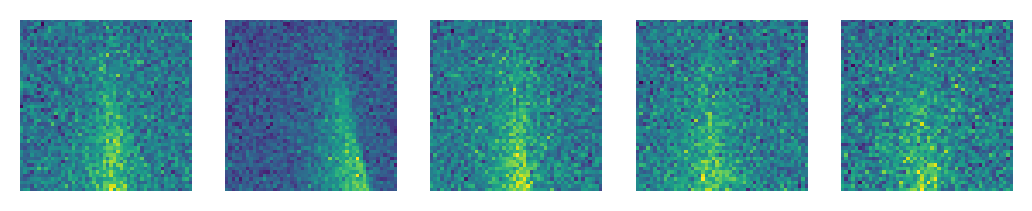

In [20]:
subkey, key = jax.random.split(key)
img_batch,_ = get_duffing_image_batch( subkey, 5, value_ranges, 
                        50, 4.0, 0.1, 1.0, 200., 400, 0.5)

fig,ax=plt.subplots(ncols=5)
for j in range(5):
    ax[j].matshow(img_batch[j,0])
    ax[j].axis('off')

As explained above, each of these images comes with two additional channels, where the other two represent frequency and force strength (which may be useful for the neural network in its task):

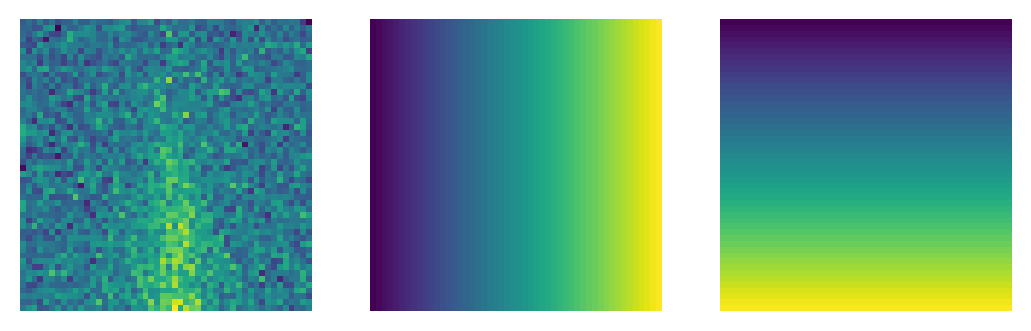

In [21]:
fig,ax=plt.subplots(ncols=3)
for j in range(3):
    ax[j].matshow(img_batch[0,j])
    ax[j].axis('off')

The question is now whether a neural network can just look at one of these images and properly guess the underlying physical parameters.

We could apply the neural network that we defined above to this problem. However, since such an image has 2500 pixels, the input vector to the network would already be getting large. As a consequence, the number of values stored inside the weight matrices (e.g. connecting these 2500 neurons to those in the next layer) would get large as well. There is, in fact, a much better option for processing images.

This option goes by the name of "convolutional neural network", which has a special-purpose structure designed for images.

### Defining a convolutional neural network

Convolutional neural networks exploit translational invariance of images. This is inspired by the observation that, e.g. for image recognition, it does not matter whether a face sits in the lower left or the upper right corner of the image, it should be treated in the same way.

The essential part of a convolutional network is the convolution of an image with a kernel or filter. This kernel is just a small image, say of size ```[K,K]```. You can think of it being swept across the input image. At each location, you collect the input pixels covered by the extent of the kernel, weighting them by the values in the kernel. This is exactly the procedure that is also implemented in image processing software, and the only difference here is that the weight values inside the kernel will be learned.

For generality, the image may have several channels (think of red, green, and blue). If the input image has ```N``` channels and the output image should have ```M``` channels, then the kernel will be an array of shape ```[M,N,K,K]```.

This is all. ```jax``` provides a general built-in convolution operation that also can do things like scaling down the image by an integer factor (using so-called "strides") at the same time as applying the convolution operation.

One small detail in using convolutions: It is always a question of how to treat pixels at the boundaries. Should one only keep output pixels where the kernel extent still fits into the input image completely (option ```VALID``` in the ```jax``` function) or should one strive to keep the image size overall the same (option ```SAME```) ?


Let us first define a small helper function for convenient access to the 2D convolution in ```jax```:

In [22]:
def conv2d( img, kernel, scalefactor ):
    """
    Shortcut for jax convolution of kernel with
    image 'img', with padding 'VALID' and possibly scaling down by
    a factor (which should ideally divide the img size).
    """
    return jax.lax.conv_general_dilated(
    img, kernel, [scalefactor,scalefactor], "VALID")


Now let us define the convolutional neural network. One standard structure in this game is to first have several convolutions (possibly coupled with downscaling). However, unless the final result should also be an image, at some point one wants to switch from images and convolutions to plain vectors and a fully connected network. This is simply done at some stage by taking all the pixels in the image across all its channels and "flattening" them into one vector, which is then fed into the usual fully connected network, to produce the final output.

Below you find the convolutional network defined in this way. Again, as activation function we simply use ```tanh```, and we re-use our previously defined fully connected network to process the vector that results from flattening.

The parameters of this network we divided into several pieces: ```conv_kernels``` and ```conv_biases``` contain the kernels and bias values for the convolutional layers, while ```dense``` itself contains entries ```weights``` and ```biases``` relating to the fully connected network that is applied in the end.

![ ](conv_network.jpg)

In [23]:
def NN_conv( x, params ):
    """
    Apply several convolutional layers and then
    switch to fully connected. The structure here
    is fixed.
    
    params must contain params['conv_kernels'],
    params['conv_biases'] for the convolutional
    part and params['dense'] containing weights
    and biases for the dense part.
    """
    # first add a fake batch dimension, because we
    # will deal with batching separately later
    # using vmap, but jax.lax.conv needs a batch
    # dimension (here of size 1):
    x = x[None,...]
    
    # apply several 2d convolutions and downscalings by
    # factor of 2:
    for kernel, bias in zip(params['conv_kernels'],params['conv_biases']):
        x = conv2d( x, kernel, 2 ) + bias[None,:,None,None]
        x = jnp.tanh( x )
        
    # now switch to dense network, "flattening"
    # the image and its channels into a single vector
    x = jnp.reshape( x, [-1] )
    
    # finally, apply the usual dense network,
    # with its weights and biases provided
    # inside params['dense']:
    return NN( x, params['dense'] )

As usual, we like our batched version of the network, and also define a loss function (mean square error as before, nothing special here):

In [24]:
# produce a batched version (where x has a batch dimension 0)
NN_conv_batch = vmap(NN_conv, in_axes=[0,None], out_axes=0)

# batch-averaged mean-square-error deviation between network output and y_target:
def mse_loss_conv_batch(x, y_target, params):
    return jnp.sum( ( NN_conv_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss. Apply jit to compile it:
mse_loss_conv_batch_val_grad = jax.jit( value_and_grad(mse_loss_conv_batch, argnums=2) )

### Initializing the parameters for a convolutional network

To initialize the parameters we proceed like usual, with the kernels as random arrays. 

The only slightly tricky part here is that the input to the fully connected network is a vector of a size that needs to be known and depends on the details of how the preceding downscaling operations and convolution operations work (including the treatment of the boundaries). This is taken care of in the function given below, but if you were to change the downscaling to a factor different from 2, you would have to slightly revise.

In [25]:
def NN_conv_init_params( key, pixel_rows, pixel_cols,
                        num_channels, kernel_sizes,
                        final_dense_layers ):
    """
    Randomly initialize the parameters needed for
    a convolutional+dense neural network.
    
    key: jax random key
    pixel_rows, pixel_cols: dimensions of input image
       (needed to properly set up the dense part!)
    num_channels: list of channels for the conv. part,
       starting with the input image channels
    kernel_sizes: listing the sizes of the kernels,
       a list of length one less than num_channels
    final_dense_layers: list of numbers of neurons in
       the final few dense layers (excluding the
       first dense layer, which results from flattening
       the convolutional output, whose neuron number is
       computed automatically from the image dim.
       given above)
       
    Returns params dictionary with entries
    'conv_kernels', 'conv_biases', and 'dense'.
    """
    params = {}
    params['conv_kernels']=[]
    params['conv_biases']=[]
    
    for lower_channels, higher_channels, kernel_size in zip( num_channels[:-1], num_channels[1:], kernel_sizes ):
        key,subkey = jax.random.split( key )
        params['conv_kernels'].append( jax.random.normal( subkey,
                                        [higher_channels,lower_channels,kernel_size,kernel_size] ) /  
                                 jnp.sqrt( lower_channels ) )
        # keep track of image shape during these convolutions and
        # downscalings! (this would change if you use 'SAME' instead of 'VALID')
        pixel_rows = ( pixel_rows - (kernel_size-1) + 1 ) // 2
        pixel_cols = ( pixel_cols - (kernel_size-1) +1 ) // 2

    for channels in num_channels[1:]:
        params['conv_biases'].append( jnp.zeros( channels ) )

    # now we switch to the dense network!
    # need to calculate the size of the input vector
    # to the fully connected (dense) network:
    neuron_num_input = num_channels[-1] * pixel_rows * pixel_cols
    key,subkey = jax.random.split( key )
    params['dense'] = NN_init_params( subkey, [neuron_num_input] + final_dense_layers )
    
    return params

### Running the training loop

Following our usual procedure, we initialize the network parameters and then initialize the optimizer on those:

In [26]:
num_physics_parameters = 3 # output dimension
npixels = 50 # size of images will be npixels * npixels
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_conv_init_params( subkey, 
                pixel_rows=npixels, pixel_cols=npixels,
                num_channels=[3,30,30,30,10], 
                kernel_sizes=[3,3,3,3],
                final_dense_layers=[50,num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

We also prepare some parameters for the training loop.

In [27]:
# training parameters
num_training_batches = 100
batchsize = 16

# parameters for the training batches:
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
noise_strength = 0.5
omega_range = 4.0 # sweep -omega_range..+omega_range
t_end = 200.0 # duration of frequency sweep
nsteps = 400 # time steps for solving dynamics in sweep
low_force = 0.1 # force sweep range
high_force = 2.0

losses=[]


And, finally, here is our training loop:

In [ ]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = get_duffing_image_batch( subkey,
                                batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength)    
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_conv_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

2025-08-14 14:51:33.582756: W external/xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:847] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2025-08-14 14:51:33.582777: W external/xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:850] Conv: %cudnn-conv-bw-filter = (f32[10,30,3,3]{3,2,1,0}, u8[0]{0}) custom-call(%tanh.2, %bitcast.3), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_name="jit(mse_loss_conv_batch)/jit(main)/conv_general_dilated" source_file="/tmp/ipykernel_64077/3499397807.py" source_line=7}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


XlaRuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bw-filter = (f32[10,30,3,3]{3,2,1,0}, u8[0]{0}) custom-call(%tanh.2, %bitcast.3), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_name="jit(mse_loss_conv_batch)/jit(main)/conv_general_dilated" source_file="/tmp/ipykernel_64077/3499397807.py" source_line=7}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}

Original error: INTERNAL: All algorithms tried for (f32[10,30,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,30,5,5]{3,2,1,0}, f32[16,10,2,2]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","reification_cost":[],"wait_on_operation_queues":[]} failed. Falling back to default algorithm.  Per-algorithm errors:
  Profiling failure on cuDNN engine eng1{k2=6,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng1{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng20{k2=5,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng20{k2=7,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng20{k2=6,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng20{k2=2,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng20{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(5888): 'status'

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

: 

Let us check the performance!

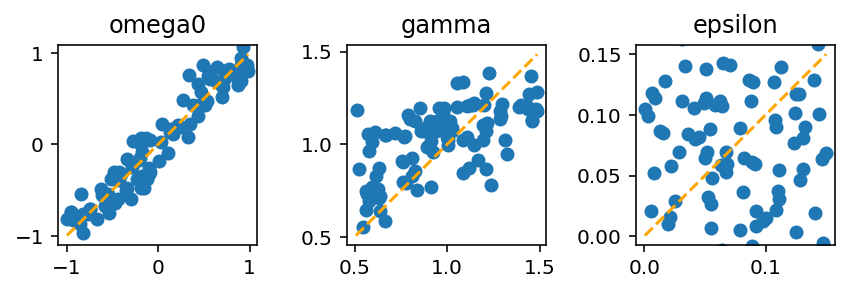

In [ ]:
validation_batchsize = 100

subkey,key = jax.random.split( key )
x, y_target = get_duffing_image_batch( subkey,
                                validation_batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength) 
y = NN_conv_batch( x, params )


fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

This works pretty well even at this small batch number, again except for the nonlinearity. 

When training on 2000 batches, I get down to mean square error of $10^{-2}$, and even the nonlinearity is extracted reasonably well. At some point, the error cannot get any better, because a noisy training curve intrinsically does not allow you to reveal the underlying parameters to arbitary precision.

**Visualizing one prediction** -- Let us visualize one of the validation samples:

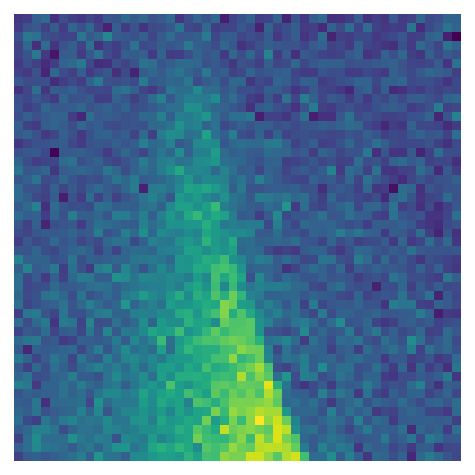

Parameters (omega0, gamma, epsilon):
True: [-0.94808793  0.77133393  0.06774363]
NN:   [-0.7443931  1.0469363  0.0696204]


In [ ]:
idx=5 # sample index
plt.matshow( x[idx,0] )
plt.axis('off')
plt.show()
print("Physical parameters (omega0, gamma, epsilon):")
print(f"True: {y_target[idx]}")
print(f"NN:   {y[idx]}")

**Parameter count** -- One of the promises of convolutional networks is that they need much less trainable parameters than a fully connected network to reach a good performance.

Let us check how many trainable parameters we have overall in our network. We use a function called ```jax.tree.map``` to iterate through all the entries of our nested dictionary / list ```params```:

In [ ]:
import math
jax.tree.map(lambda z: math.prod(jnp.shape(z)), params)

{'conv_biases': [30, 30, 30, 10],
 'conv_kernels': [810, 8100, 8100, 2700],
 'dense': {'biases': [50, 3], 'weights': [2000, 150]}}

Each of these numbers indicates the amount of values stored inside one of the matrices or vectors that make up ```params```. As we can see, there are **far** fewer parameters than what we would have needed in a fully connected network: There, the  50 by 50 input image has 2500 pixels and if we were to choose a first hidden layer of 100 neurons, this would already need 250,000 parameters in the weight matrix connecting these two layers alone!

```{admonition} Exercise
Train for longer (up to 2000 batches) and see how the performance improves. Try the same with smaller or larger noise strength.
```

```{admonition} Exercise
Change the physical scenario by using a much smaller sweep duration (e.g. t_end=10 instead of 200). This creates distored response curves. See how the neural network still can be trained to extract parameters from that.
```

```{admonition} Exercise
Try to vary the setup of our network, e.g. the number of convolutional layers, the number of their channels, the kernel sizes, and the number of fully connected layers or their neuron numbers. Explore what is the minimal network structure to get reasonable performance.
```

```{admonition} Outlook
From here, you can branch out: Try, for example, to feed into the network both parts of the response (real and imaginary parts of the complex response z). This should improve the performance. Or try to add additional physics parameters inside a modified evolution equation (nonlinear damping?) and explore how well these can be extracted by the neural network. Start exploring other physical systems with their own evolution equation.
```

```{admonition} Advanced exercise
Train a second neural network to predict the expected precision of our existing neural network in the case with noisy samples.
```